# Модель предсказания размера и периодичности взносов участников НПО

Описание: В течение многих столетий доля пожилых людей старше 60 лет не превышала 10% от общего числа людей. Однако, с развитием промышленности, технологий, повышением качества здравоохранения, по прогнозам демографов доля пожилого населения может достигнуть 30% к середине столетия, а медианный возраст населения развитых стран достигнет 55 лет. В связи с этим становится актуальной проблема благополучия пожилых людей. Программы негосударственного пенсионного обеспечения (НПО) предоставляют возможность формирования дополнительного пенсионного капитала.

Участникам предлагается разработать прототип сервиса прогнозирования размера и периодичности взносов участников НПО, с акцентом на интерпретируемость с точки зрения использованных (сгенерированных) данных. Понимание факторов, влияющих на изменение финансового поведения участников, является важным как с точки зрения государства, так и нашей компании.

В представленном архиве вы можете увидеть три файла следующего содержания.
1. Файл *npo_clnts.csv* содержит информацию о клиентах НПО, а именно следующие поля:
	- **clnt_id** - ID клиента
	- **slctn_nmbr** - Номер выборки
	- **gndr** - Пол клиента: "м": "0", "ж": "1"
	- **age** - Возраст клиента, лет
	- **brth_yr** - Год рождения клиента
	- **pstl_code** - Почтовый индекс
	- **city** - Живет клиент в городе (1) или нет (0)
2. Файл *npo_cntrbtrs.csv* содержит информацию о статусах счетов клиентов НПО, а именно следующие поля:
	- **npo_accnt_id** - ID счета клиента
	- **client_id** - ID клиента
	- **slctn_nmbr** - Номер выборки
	- **accnt_pnsn_schm** - Условный код пенсионной схемы счета клиента
	- **npo_accnt_status** - Статус счета клиента: "Закрыт": "0", "Открыт": "1"
	- **npo_accnt_status_date** - Дата статуса счета клиента
	- **npo_blnc** - Баланс счета клиента, руб.
	- **npo_pmnts_sum** - Сумма взносов клиента, руб.
	- **npo_pmnts_nmbr** - Число взносов клиента
	- **npo_frst_pmnt_date** - Дата первого взноса клиента
	- **npo_lst_pmnt_date** - Дата последнего взноса клиента 
	- **npo_ttl_incm** - Сумма дохода, начисленного на счет клиента, руб.
3. Файл *npo_trnsctns.csv* содержит информацию о транзациях клиентов НПО, а именно следующие поля:
	- **npo_accnt_id** - ID счета клиента
	- **slctn_nmbr** - Номер выборки
	- **npo_sum** - Размер операции по счету клиента, руб.
	- **npo_operation_date** - Дата взноса клиента
	- **npo_operation_group** - Тип операции по счету клиента: "Поступление взносов": "0", "Начисление дохода": "1"

## План

1. Провести первичный анализ данных

    а. проверить данные на пропуски

    б. Посмотреть характер распределения данных
    
    в. Провести графисекий анализ данных
    
    г. Сформулировать предложения по устранению недостатков в данных
    
    д. Сформулировать вопросы по бизнесс процессу

2. Построение модели.

    а. объеденить данные

    б. Заполнить пропуски в данных

    в. Убрать выбросы из данных

    г. разделить выборки на тренировочную и тестовую

    д. шкалировать данные

    е. отобрать нужные переменные

    ж. попробовать разные модели (линейная регрессия, рандомный лес, градиентный бустинг, нейронные сети)

    з. оценить построенные модели по разным метрикам


3. Написать отчёт о проделанной работе

    а. Проверить модель на тестовой выборке

    б. Описать полученные оценки, сделать выводы

    в. Написать заключение

In [188]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shap
import sklearn

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest 
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import SGDRegressor
from scipy.stats import probplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from catboost import cv
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from catboost.utils import create_cd
from catboost.eval.catboost_evaluation import *
from catboost.eval.evaluation_result import *
from catboost.utils import get_roc_curve
from sklearn import metrics


In [189]:
clnts = pd.read_csv('npo_clnts.csv')
cntrbtrs = pd.read_csv('npo_cntrbtrs.csv')
trnsctns = pd.read_csv('C:/npo_trnsctns.csv')


In [190]:
# Прибавление 487 дней к датам в файле npo_cntrbtrs.csv
cntrbtrs['npo_accnt_status_date'] = pd.to_datetime(cntrbtrs['npo_accnt_status_date']) + pd.Timedelta(days=487)
cntrbtrs['npo_frst_pmnt_date'] = pd.to_datetime(cntrbtrs['npo_frst_pmnt_date']) + pd.Timedelta(days=487)
cntrbtrs['npo_lst_pmnt_date'] = pd.to_datetime(cntrbtrs['npo_lst_pmnt_date']) + pd.Timedelta(days=487)

# Прибавление 487 дней к датам в файле npo_trnsctns.csv
trnsctns['npo_operation_date'] = pd.to_datetime(trnsctns['npo_operation_date']) + pd.Timedelta(days=487)


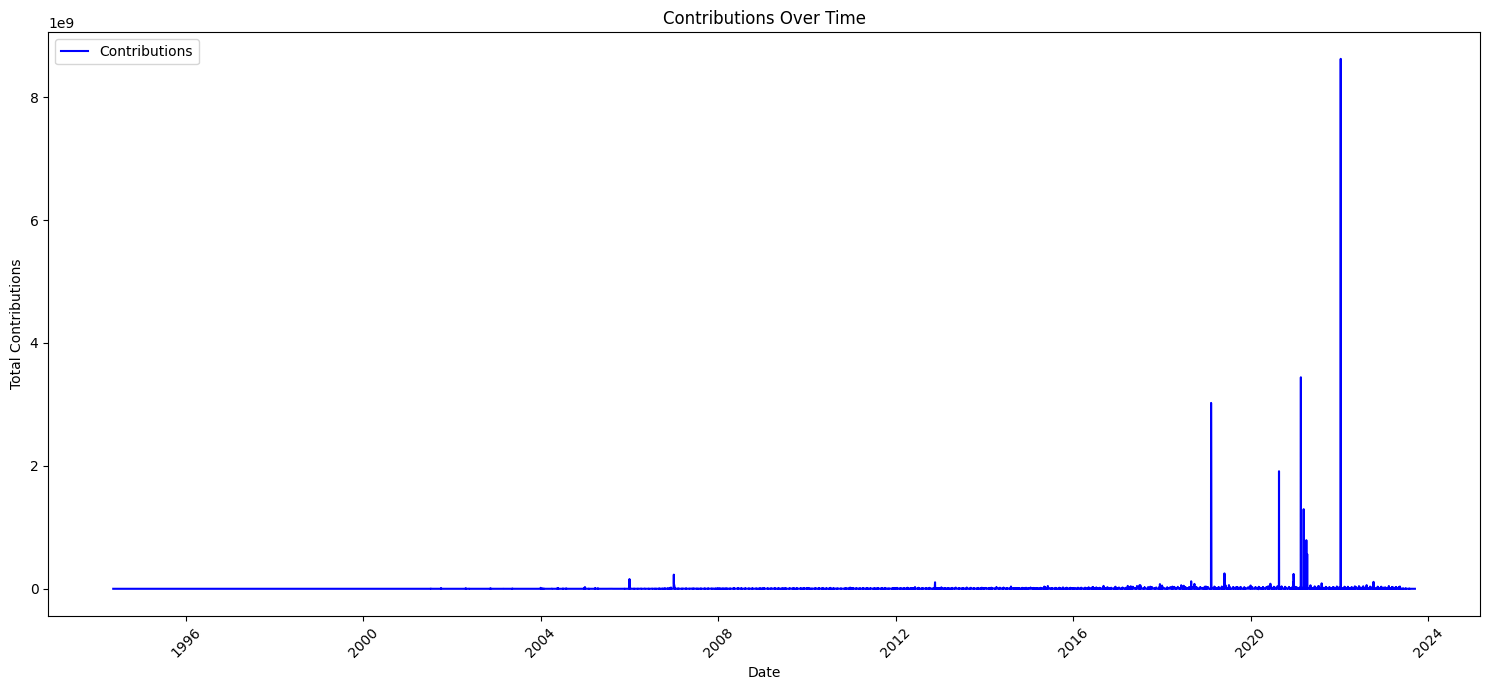

In [191]:
# Отфильтровать данные для операций "Поступление взносов"
contributions = trnsctns[trnsctns['npo_operation_group'] == 0]

# Группировка по дате и суммирование платежей
grouped_contributions = contributions.groupby('npo_operation_date')['npo_sum'].sum()

plt.figure(figsize=(15, 7))

# Построение графика
plt.plot(grouped_contributions.index, grouped_contributions.values, label='Contributions', color='blue')

# Настройка графика
plt.title('Contributions Over Time')
plt.xlabel('Date')
plt.ylabel('Total Contributions')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()


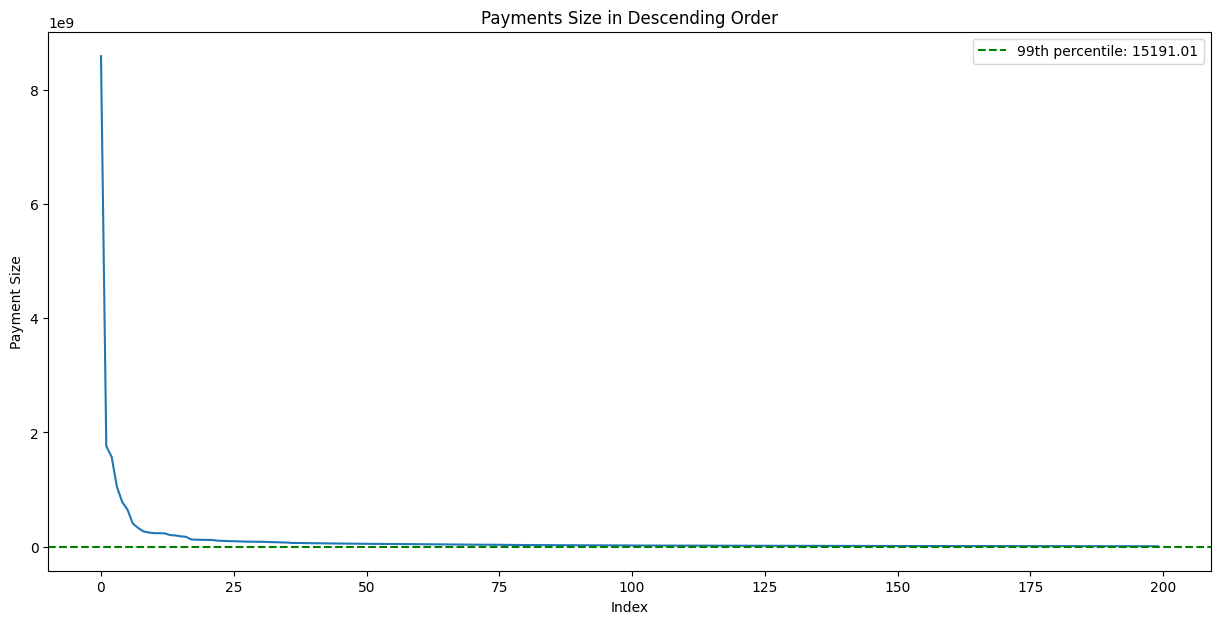

In [192]:
# Сортировка платежей по убыванию
sorted_payments = trnsctns['npo_sum'].sort_values(ascending=False).reset_index(drop=True)
sorted_payments = sorted_payments[0:200]
plt.figure(figsize=(15, 7))
plt.plot(sorted_payments)
plt.axhline(y=q99, color='g', linestyle='--', label=f"99th percentile: {q99:.2f}")
plt.title('Payments Size in Descending Order')
plt.xlabel('Index')
plt.ylabel('Payment Size')
plt.legend()
plt.show()


In [193]:
from sklearn.ensemble import IsolationForest

# Создаем модель
clf = IsolationForest(contamination=0.001)  # contamination - это доля аномалий в данных
outliers = clf.fit_predict(trnsctns[['npo_sum']])
trnsctns['anomaly'] = outliers
anomalies = trnsctns[trnsctns['anomaly'] == -1]



c:\Users\Денис\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



In [194]:
trnsctns = trnsctns[trnsctns['anomaly'] == 1]

In [195]:
regions = {
    "Республика Адыгея": [385],
    "Республика Алтай": [649],
    "Алтайский край": list(range(656, 660)),
    "Амурская область": list(range(675, 677)),
    "Архангельская область": list(range(163, 166)),
    "Астраханская область": list(range(414, 417)),
    "Республика Башкортостан": list(range(450, 454)),
    "Белгородская область": list(range(308, 310)),
    "Брянская область": list(range(241, 244)),
    "Республика Бурятия": list(range(670, 672)),
    "Владимирская область": list(range(600, 603)),
    "Волгоградская область": list(range(400, 405)),
    "Вологодская область": list(range(160, 163)),
    "Воронежская область": list(range(394, 398)),
    "Республика Дагестан": list(range(367, 369)),
    "Еврейская автономная область": [679],
    "Забайкальский край": list(range(672, 675)) + [687],
    "Ивановская область": list(range(153, 156)),
    "Республика Ингушетия": [386],
    "Иркутская область": list(range(664, 667)) + [669],
    "Кабардино-Балкарская Республика": list(range(360, 362)),
    "Калининградская область": list(range(236, 239)),
    "Республика Калмыкия": list(range(358, 360)),
    "Калужская область": list(range(248, 250)),
    "Камчатский край": list(range(683, 685)) + [688],
    "Карачаево-Черкесская Республика": [369],
    "Республика Карелия": list(range(185, 187)),
    "Кемеровская область": list(range(650, 655)),
    "Кировская область": list(range(610, 614)),
    "Республика Коми": list(range(167, 170)),
    "Костромская область": list(range(156, 158)),
    "Краснодарский край": list(range(350, 355)),
    "Красноярский край": list(range(660, 664)) + [647, 648],
    "Республика Крым": list(range(295, 299)),
    "Курганская область": list(range(640, 642)),
    "Курская область": list(range(305, 308)),
    "Ленинградская область": list(range(187, 189)),
    "Липецкая область": list(range(398, 400)),
    "Магаданская область": list(range(685, 687)),
    "Республика Марий Эл": list(range(424, 426)),
    "Республика Мордовия": list(range(430, 432)),
    "г. Москва": list(range(101, 136)),
    "Московская область": list(range(140, 145)),
    "Мурманская область": list(range(183, 185)),
    "Ненецкий автономный округ": [166],
    "Нижегородская область": list(range(603, 608)),
    "Новгородская область": list(range(173, 176)),
    "Новосибирская область": list(range(630, 634)),
    "Омская область": list(range(644, 647)),
    "Оренбургская область": list(range(460, 463)),
    "Орловская область": list(range(302, 304)),
    "Пензенская область": list(range(440, 443)),
    "Пермский край": list(range(614, 620)),
    "Приморский край": list(range(690, 693)),
    "Псковская область": list(range(180, 183)),
    "Ростовская область": list(range(344, 348)),
    "Рязанская область": list(range(390, 392)),
    "Самарская область": list(range(443, 447)),
    "г. Санкт-Петербург": list(range(190, 200)),
    "Саратовская область": list(range(410, 414)),
    "Республика Саха (Якутия)": list(range(677, 679)),
    "Сахалинская область": list(range(693, 695)),
    "Свердловская область": list(range(620, 625)),
    "г. Севастополь": [299],
    "Северная Осетия": list(range(362, 364)),
    "Смоленская область": list(range(214, 217)),
    "Ставропольский край": list(range(355, 358)),
    "Тамбовская область": list(range(392, 394)),
    "Республика Татарстан": list(range(420, 424)),
    "Тверская область": list(range(170, 173)),
    "Томская область": list(range(634, 637)),
    "Тульская область": list(range(300, 302)),
    "Республика Тыва (Тува)": list(range(667, 669)),
    "Тюменская область": list(range(625, 628)),
    "Удмуртская Республика": list(range(426, 428)),
    "Ульяновская область": list(range(432, 434)),
    "Хабаровский край": list(range(680, 683)),
    "Республика Хакасия": [655],
    "Ханты-Мансийский автономный округ": [628],
    "Челябинская область": list(range(454, 458)),
    "Чеченская Республика": list(range(364, 367)),
    "Чувашская Республика": list(range(428, 430)),
    "Чукотский автономный округ": [689],
    "Ямало-Ненецкий автономный округ": [629],
    "Ярославская область": list(range(150, 153)),
     "Дополнительные почтовые отделения": [800],
}

In [196]:
# Преобразуем словарь regions так, чтобы каждому индексу соответствовало название региона
index_to_region = {index: region for region, indices in regions.items() for index in indices}

# Преобразуем значения в колонке 'pstl_code' к строковому типу и извлекаем первые 3 символа
clnts['pstl_code3'] = clnts['pstl_code'].astype(str).str.split('.').str[0].str[:3]
#заменяем все что не три цыфры на 800
clnts.loc[~clnts['pstl_code3'].str.match("^\d{3}$"), 'pstl_code3'] = "800"
clnts['pstl_code3'] = clnts['pstl_code3'].fillna(0)
clnts['pstl_code3'] = clnts['pstl_code3'].astype(int)
# Создаем новую колонку 'region', используя словарь index_to_region
clnts['region'] = clnts['pstl_code3'].map(index_to_region)

print(clnts.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230446 entries, 0 to 230445
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clnt_id     230446 non-null  object 
 1   gndr        230442 non-null  float64
 2   slctn_nmbr  230446 non-null  int64  
 3   age         230423 non-null  float64
 4   brth_yr     230423 non-null  float64
 5   pstl_code   220185 non-null  object 
 6   city        230446 non-null  int64  
 7   pstl_code3  230446 non-null  int32  
 8   region      230239 non-null  object 
dtypes: float64(3), int32(1), int64(2), object(3)
memory usage: 14.9+ MB
None


In [197]:
# Отфильтровываем транзакции с типом операции "Поступление взносов"
filtered_trnsctns = trnsctns[trnsctns['npo_operation_group'] == 0]

# Группировка данных по npo_accnt_id и кварталам
grouped_trnsctns = filtered_trnsctns.groupby(['npo_accnt_id', pd.PeriodIndex(filtered_trnsctns['npo_operation_date'], freq='Q')])

# Подсчет количества и суммы платежей
quarterly_payments = grouped_trnsctns['npo_sum'].agg(['count', 'sum']).reset_index()

# Среднее количество платежей за квартал
avg_payments_per_quarter = quarterly_payments.groupby('npo_accnt_id')['count'].mean().reset_index()
avg_payments_per_quarter.rename(columns={'count': 'avg_payments_per_quarter'}, inplace=True)

# Общее количество платежей и средний размер платежа
total_payments = grouped_trnsctns['npo_sum'].agg(['count', 'mean']).reset_index()
total_payments.rename(columns={'count': 'total_payments', 'mean': 'avg_payment_size'}, inplace=True)

# Объединение данных с cntrbtrs
cntrbtrs = pd.merge(cntrbtrs, avg_payments_per_quarter, on='npo_accnt_id', how='left')


In [198]:
# Группировка данных по npo_accnt_id для подсчета общего количества платежей
total_payments_count = filtered_trnsctns.groupby('npo_accnt_id')['npo_sum'].count().reset_index()
total_payments_count.rename(columns={'npo_sum': 'total_payments_count'}, inplace=True)

# Объединение данных с cntrbtrs
cntrbtrs = pd.merge(cntrbtrs, total_payments_count, on='npo_accnt_id', how='left')


In [199]:
# Фильтрация данных по типу операции "Поступление взносов"
trnsctns = trnsctns[trnsctns['npo_operation_group'] == 0]

# Преобразование даты операции в формат квартала
trnsctns['quarter'] = pd.to_datetime(trnsctns['npo_operation_date']).dt.to_period('Q')

# Группировка данных по npo_accnt_id и кварталу, суммирование сумм операций
quarterly_sums = trnsctns.groupby(['npo_accnt_id', 'quarter'])['npo_sum'].sum().unstack().reset_index()

# Объединение данных с npo_cntrbtrs.csv
cntrbtrs_with_quarterly_sums = pd.merge(cntrbtrs, quarterly_sums, on='npo_accnt_id', how='left')

print(cntrbtrs_with_quarterly_sums.head())



                         npo_accnt_id                             clnt_id  \
0  0x90B7458B8CBFF24980DEC312BA4A1AF5  0x85390230E8955E4FA736E62B0F0E3844   
1  0xC64D3161D31A8441A65224792D370CB3  0xC2B51FD4FE57F7479210FD7258DF5B0B   
2  0xC92F1AA5587E2348BEF17432FBD6C2E6  0x8EC850934FF06A4AA0A856CF43B8D666   
3  0x8DDD2D186B990F43AD5FC9F5C7124E16  0xAF0A0745F8241548B01C4CDA068C51E8   
4  0xA7F12C768A4FB38311E835E81716D8CD  0x943D2C768A4FB38311E65C7B0420641F   

   accnt_pnsn_schm  slctn_nmbr  npo_accnt_status npo_accnt_status_date  \
0              1.0           0                 1            2002-09-13   
1              3.0           2                 0            2020-02-29   
2              4.0           1                 0            2015-05-22   
3              5.0           0                 0            2020-09-28   
4              7.0           3                 1            2008-08-15   

   npo_blnc  npo_pmnts_sum  npo_pmnts_nmbr npo_frst_pmnt_date  ... 2021Q2  \
0  10158.96    

In [200]:
for i in cntrbtrs_with_quarterly_sums.columns:
    print(i)


npo_accnt_id
clnt_id
accnt_pnsn_schm
slctn_nmbr
npo_accnt_status
npo_accnt_status_date
npo_blnc
npo_pmnts_sum
npo_pmnts_nmbr
npo_frst_pmnt_date
npo_lst_pmnt_date
npo_ttl_incm
avg_payments_per_quarter
total_payments_count
1994Q2
1994Q3
1994Q4
1995Q1
1995Q2
1995Q3
1995Q4
1996Q1
1996Q2
1996Q3
1996Q4
1997Q1
1997Q2
1997Q3
1997Q4
1998Q1
1998Q2
1998Q3
1998Q4
1999Q1
1999Q2
1999Q3
1999Q4
2000Q1
2000Q2
2000Q3
2000Q4
2001Q1
2001Q2
2001Q3
2001Q4
2002Q1
2002Q2
2002Q3
2002Q4
2003Q1
2003Q2
2003Q3
2003Q4
2004Q1
2004Q2
2004Q3
2004Q4
2005Q1
2005Q2
2005Q3
2005Q4
2006Q1
2006Q2
2006Q3
2006Q4
2007Q1
2007Q2
2007Q3
2007Q4
2008Q1
2008Q2
2008Q3
2008Q4
2009Q1
2009Q2
2009Q3
2009Q4
2010Q1
2010Q2
2010Q3
2010Q4
2011Q1
2011Q2
2011Q3
2011Q4
2012Q1
2012Q2
2012Q3
2012Q4
2013Q1
2013Q2
2013Q3
2013Q4
2014Q1
2014Q2
2014Q3
2014Q4
2015Q1
2015Q2
2015Q3
2015Q4
2016Q1
2016Q2
2016Q3
2016Q4
2017Q1
2017Q2
2017Q3
2017Q4
2018Q1
2018Q2
2018Q3
2018Q4
2019Q1
2019Q2
2019Q3
2019Q4
2020Q1
2020Q2
2020Q3
2020Q4
2021Q1
2021Q2
2021Q3
2021Q4
20

In [201]:
quarters = [f"{year}Q{quarter}" for year in range(1994, 2024) for quarter in range(1, 5)]

quarters_periods = [pd.Period(quarter) for quarter in quarters]

# Удаление указанных кварталов из списка
quarters_periods = [quarter for quarter in quarters_periods if quarter not in [pd.Period('1994Q1'), pd.Period('2023Q4')]]

def safe_mode(series):
    modes = series.mode()
    if modes.empty:
        return None
    return modes.iloc[0]

aggregations = {
    'npo_accnt_id': 'count',
    'npo_frst_pmnt_date': 'min',
    'npo_lst_pmnt_date': 'max',
    'npo_blnc': 'sum',
    'npo_pmnts_sum': 'sum',
    'npo_pmnts_nmbr': 'sum',
    'npo_ttl_incm': 'sum',
    'npo_accnt_status': lambda x: 1 if any(x == "1") else "0",
    'accnt_pnsn_schm': safe_mode,
    'slctn_nmbr': safe_mode,
    'avg_payments_per_quarter': 'mean',
    'total_payments_count': 'sum'
}

for quarter in quarters_periods:
    aggregations[quarter] = 'sum'

# Группировка и агрегация
grouped_cntrbtrs = cntrbtrs_with_quarterly_sums.groupby('clnt_id').agg(aggregations).reset_index()

# Объединение с clnts
merged_data = pd.merge(clnts, grouped_cntrbtrs, left_on='clnt_id', right_on='clnt_id', how='left')

# Сохранение результата
merged_data.to_csv('merged_data.csv', index=False)



In [202]:
dohod = pd.read_excel('dop/dohod.xlsx')
nasel = pd.read_excel('dop/nasel.xlsx')
no_job = pd.read_excel('dop/no_job.xlsx')
rab = pd.read_excel('dop/rab.xlsx')
val = pd.read_excel('dop/val.xlsx')
econ = pd.read_excel('dop/econ.xlsx')

In [203]:
#фукция которая рисует гистограмму и боксплот для оценки выбросов и распрелделения 
def description_and_plot (data, column):
    stat = data[column].describe()
    print(f'Описательная статистика столбца "{column}":\n'
         f'Среднее: {round(stat[1],2)}±{round(stat[2]/math.sqrt(stat[0]),2)}\n'
         f'Медиана: {round(stat[5],2)}, межквартильный размах: {round(stat[6]-stat[4],2)}\n'
         f'Минимальное значение: {round(stat[3],2)}. Максимальное значение: {round(stat[7],2)}.\n' 
         f'Нижняя граница выбросов: {round(stat[4] - 1.5 * (stat[6]-stat[4]),2)}.\n'
         f'Верхняя граница выбросов: {round(stat[6] + 1.5 *(stat[6]-stat[4]),2)}.' 
         )
    
    min_emissions = stat[4] - 1.5 * (stat[6]-stat[4])
    max_emissions = stat[6] + 1.5 *(stat[6]-stat[4])
    plt.figure(figsize=(16, 5))
    g = sns.histplot(data=data, x=data[column], kde=True)
    
    plt.show()
    plt.figure(figsize=(16, 1))
    sns.boxplot(x=data[column]).set(ylabel=' \n \n')
    plt.show()
    return ()#min_emissions, max_emissions)

In [204]:
merged_data.columns = merged_data.columns.astype(str)

# Группа 1: Вышедшие на пенсию
retired_clients = merged_data[merged_data.filter(regex='20[12][0-9]Q[1-4]').apply(lambda row: any(row < 0), axis=1)]

# Группа 2: Закрыли счет
# Определяем последние два года
last_two_years = sorted(merged_data.filter(regex='20[12][0-9]Q[1-4]').columns)[-8:]
closed_account_clients = merged_data[merged_data[last_two_years].apply(lambda row: all(row == 0), axis=1)]

# Группа 3: Активные клиенты
active_clients = merged_data[merged_data[last_two_years].apply(lambda row: any(row > 0), axis=1)]

print(f"Количество клиентов, вышедших на пенсию: {len(retired_clients)}")
print(f"Количество клиентов, закрывших счет: {len(closed_account_clients)}")
print(f"Количество активных клиентов: {len(active_clients)}")


Количество клиентов, вышедших на пенсию: 1316
Количество клиентов, закрывших счет: 176281
Количество активных клиентов: 54154


Описательная статистика столбца "avg_payments_per_quarter":
Среднее: 2.8±0.0
Медиана: 2.92, межквартильный размах: 0.28
Минимальное значение: 1.0. Максимальное значение: 20.54.
Нижняя граница выбросов: 2.32.
Верхняя граница выбросов: 3.46.


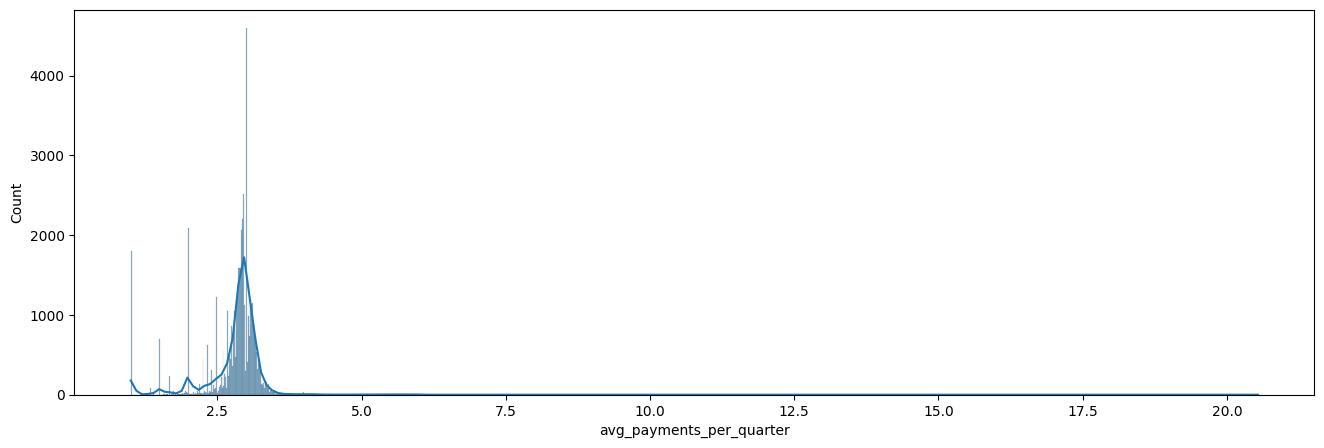

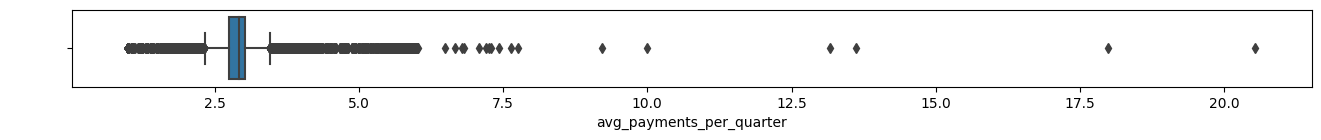

()

In [205]:
description_and_plot(data=active_clients, column='avg_payments_per_quarter')

Описательная статистика столбца "total_payments_count":
Среднее: 75.9±0.26
Медиана: 66.0, межквартильный размах: 80.0
Минимальное значение: 1.0. Максимальное значение: 1043.0.
Нижняя граница выбросов: -92.0.
Верхняя граница выбросов: 228.0.


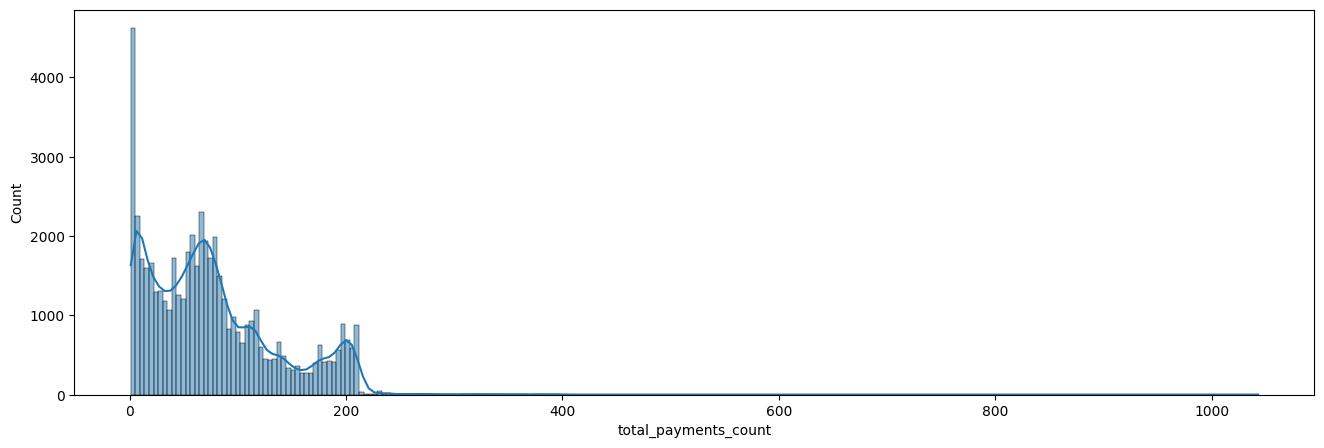

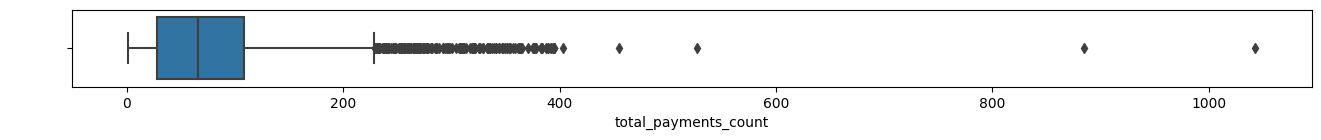

()

In [206]:
description_and_plot(data=active_clients, column='total_payments_count')

Описательная статистика столбца "2023Q3":
Среднее: 173.56±6.8
Медиана: 0.0, межквартильный размах: 0.0
Минимальное значение: 0.0. Максимальное значение: 76016.26.
Нижняя граница выбросов: 0.0.
Верхняя граница выбросов: 0.0.


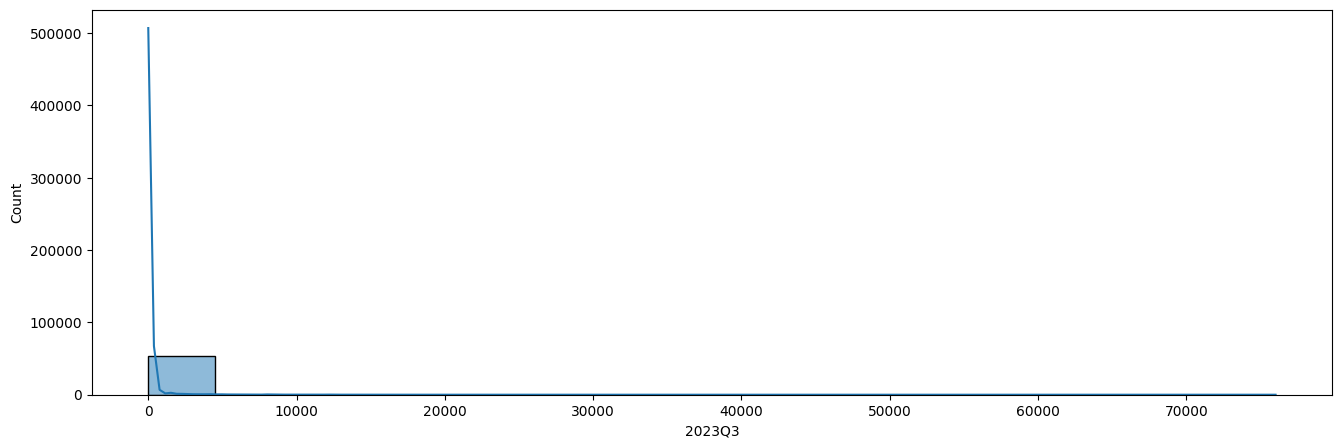

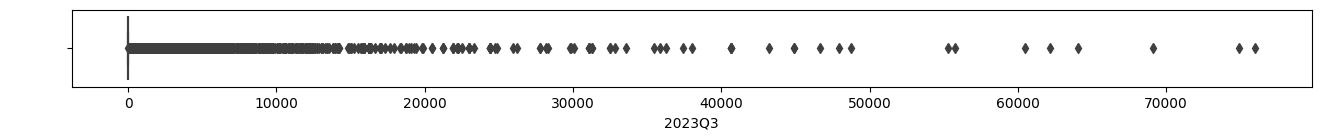

()

In [207]:
description_and_plot(data=active_clients, column='2023Q3')

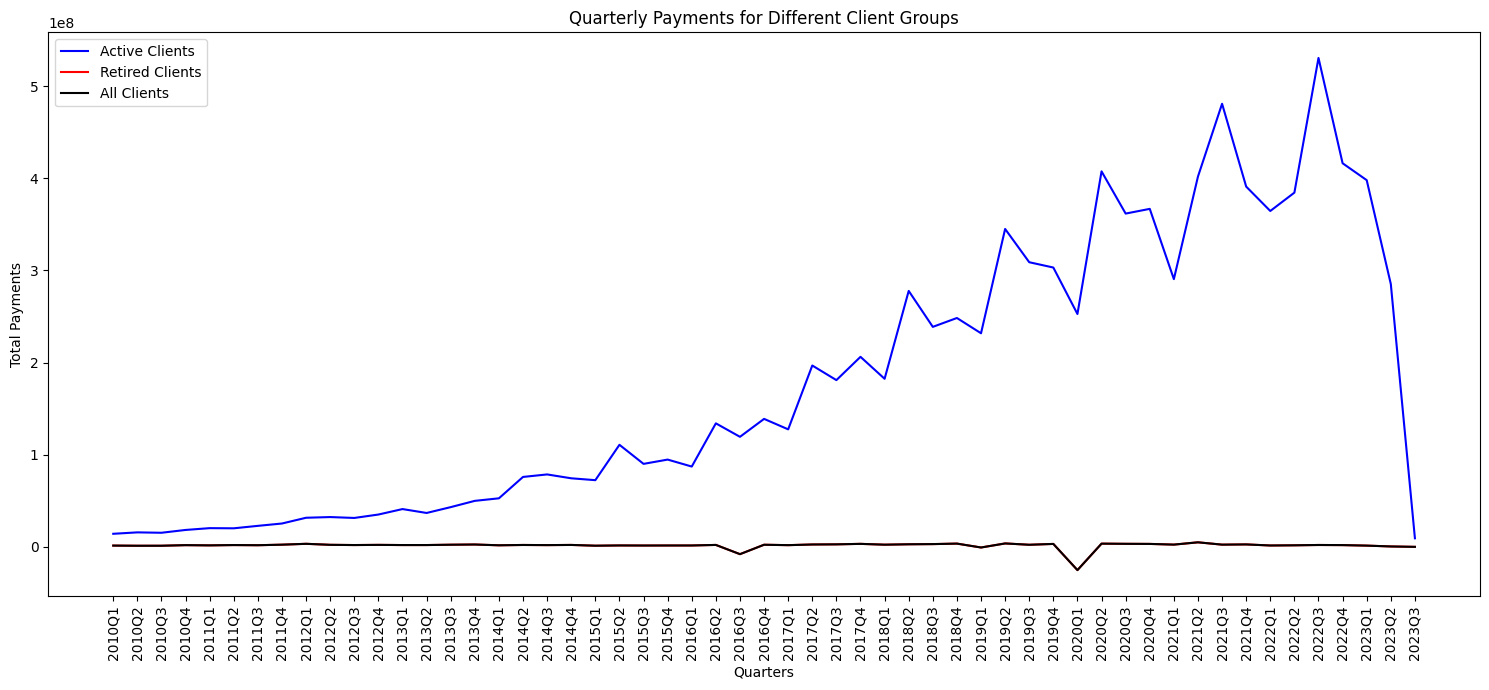

In [208]:
import matplotlib.pyplot as plt

quarters = [
    '2010Q1', '2010Q2', '2010Q3',
    '2010Q4', '2011Q1', '2011Q2', '2011Q3', '2011Q4', '2012Q1', '2012Q2', '2012Q3', '2012Q4', '2013Q1', '2013Q2',
    '2013Q3', '2013Q4', '2014Q1', '2014Q2', '2014Q3', '2014Q4', '2015Q1', '2015Q2', '2015Q3', '2015Q4', '2016Q1',
    '2016Q2', '2016Q3', '2016Q4', '2017Q1', '2017Q2', '2017Q3', '2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4',
    '2019Q1', '2019Q2', '2019Q3', '2019Q4', '2020Q1', '2020Q2', '2020Q3', '2020Q4', '2021Q1', '2021Q2', '2021Q3',
    '2021Q4', '2022Q1', '2022Q2', '2022Q3', '2022Q4', '2023Q1', '2023Q2', '2023Q3'
]

# Суммируем платежи по кварталам для каждой группы
active_sum = active_clients[quarters].sum()
retired_sum = retired_clients[quarters].sum()
all_sum = merged_data = retired_clients[quarters].sum()

plt.figure(figsize=(15, 7))

# Построение графиков
plt.plot(quarters, active_sum, label='Active Clients', color='blue')
plt.plot(quarters, retired_sum, label='Retired Clients', color='red')

plt.plot(quarters, all_sum, label='All Clients', color='black')

# Настройка графика
plt.title('Quarterly Payments for Different Client Groups')
plt.xlabel('Quarters')
plt.ylabel('Total Payments')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()

plt.show()


In [209]:
# Замена для datetime64
active_clients.loc[:, active_clients.dtypes == 'datetime64[ns]'] = active_clients.loc[:, active_clients.dtypes == 'datetime64[ns]'].fillna(pd.Timestamp('2010-01-01'))

# Замена для float64, int32 и int64
numeric_cols = active_clients.select_dtypes(include=['float64', 'int32', 'int64']).columns
for col in numeric_cols:
    active_clients[col].fillna(active_clients[col].median(), inplace=True)

# Замена для object
active_clients.loc[:, active_clients.dtypes == 'object'] = active_clients.loc[:, active_clients.dtypes == 'object'].fillna('zamena')


In [210]:
X = active_clients.drop(['2023Q3','2023Q2', 'clnt_id', 'pstl_code', 'region'], axis=1)
y = active_clients['2023Q2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [211]:
def diagnostics(y, y_pred):
    residuals = y - y_pred
    residuals_mean = np.round(np.mean(y - y_pred), 3)
 
    f, ((ax_rkde, ax_prob), (ax_yy, ax_ykde)) = plt.subplots(nrows = 2,
                                                                             ncols = 2,
                                                                             figsize = (12, 12))
 
  # в первом подграфике построим график плотности
    sns.kdeplot(residuals, fill = True, ax = ax_rkde)
    ax_rkde.set_title('Residuals distribution', fontsize = 14)
    ax_rkde.set(xlabel = f'Residuals, mean: {residuals_mean}')
    ax_rkde.set(ylabel = 'Density')
 
  # во втором график нормальной вероятности остатков
    probplot(residuals, dist = 'norm', plot = ax_prob)
    ax_prob.set_title('Residuals probability plot', fontsize = 14)
 

 
    # на четвертом сравним прогнозные и фактические значения
    ax_yy.scatter(y, y_pred)
    ax_yy.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw = 1)
    ax_yy.set_title('Actual vs. Predicted', fontsize = 14)
    ax_yy.set(xlabel = 'y_true')
    ax_yy.set(ylabel = 'y_pred')
 
    sns.kdeplot(y, fill = True, ax = ax_ykde, label = 'y_true')
    sns.kdeplot(y_pred, fill = True, ax = ax_ykde, label = 'y_pred')
    ax_ykde.set_title('Actual vs. Predicted Distribution', fontsize = 14)
    ax_ykde.set(xlabel = 'y_true and y_pred')
    ax_ykde.set(ylabel = 'Density')
    ax_ykde.legend(loc = 'upper right', prop = {'size': 12})
 
    plt.tight_layout()
 
    plt.show()

In [212]:
model_result = pd.DataFrame({'Name': [],
                             'MAE' : []}
                             )

In [213]:
linear_model = LinearRegression()
X_train2 = pd.get_dummies(X_train)
# Выбор только числовых столбцов
X_train_numeric = X_train2.select_dtypes(include=[np.number])

scores = cross_val_score(linear_model, X_train_numeric, y_train, cv=10, scoring='neg_mean_absolute_error')
mean_absolute_errors = -scores
linear_model.fit(X_train_numeric, y_train)
mean_mae = np.mean(mean_absolute_errors)
print("Средняя средняя абсолютная ошибка:", mean_mae)
model_result.loc[ len(model_result.index)] = [linear_model, mean_mae]

Средняя средняя абсолютная ошибка: 1995.672629497236


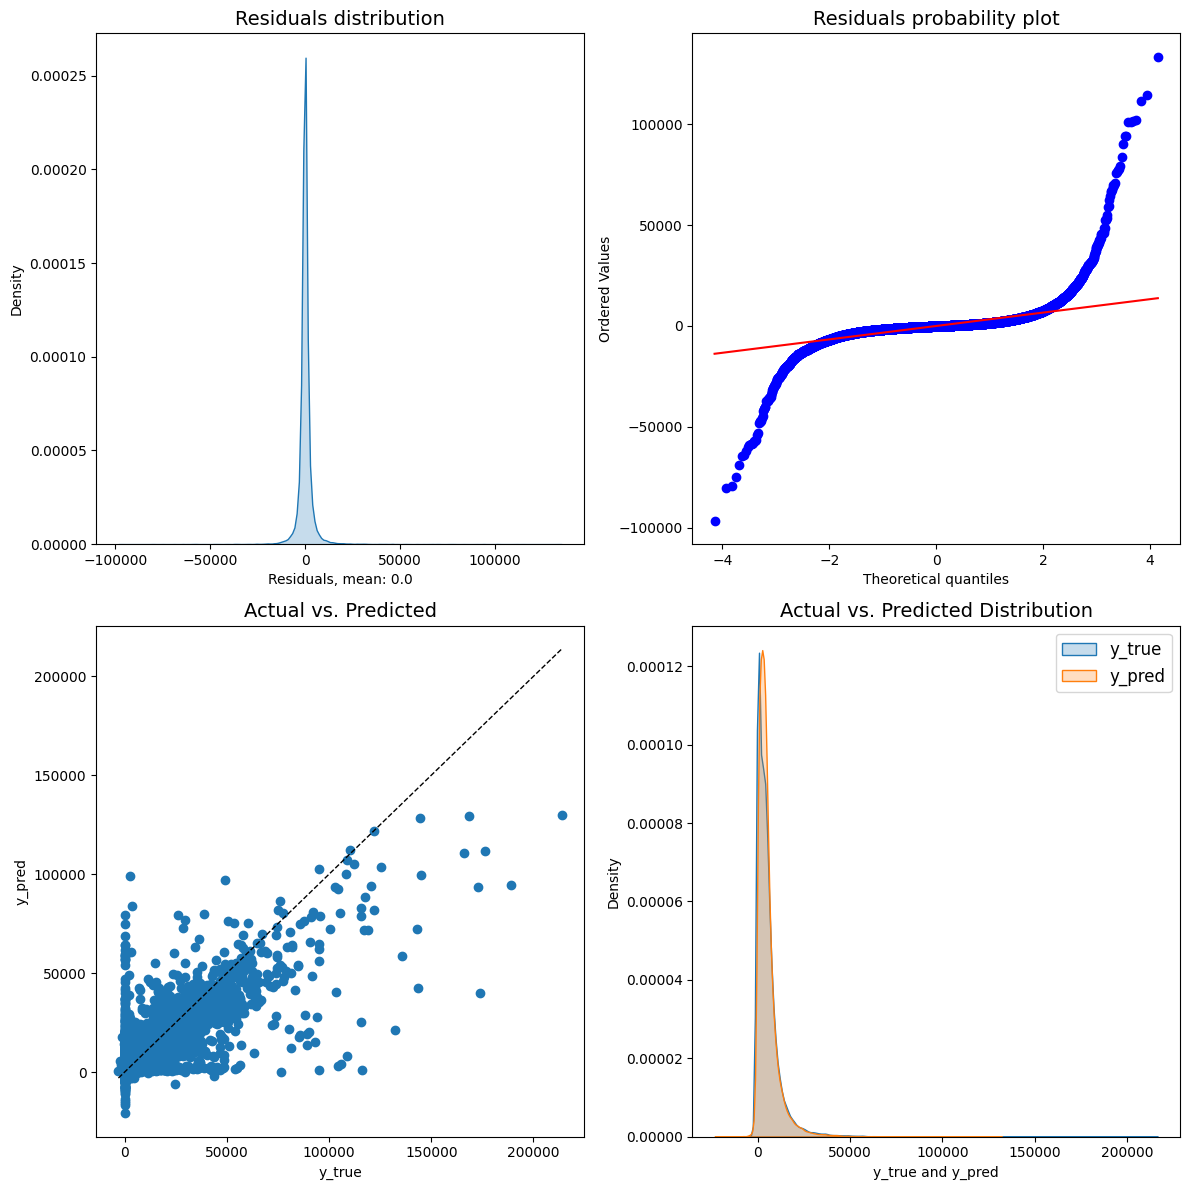

In [214]:
y_pred = linear_model.predict(X_train_numeric)
diagnostics(y_train, y_pred)

In [215]:
param_dist = {"eta0": [ .001, .003, .01, .03, .1, .3]} 
linear_regression_model = SGDRegressor(tol=.0001) 
n_iter_search = 8
random_search = RandomizedSearchCV(linear_regression_model, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search, 
                                   cv=10, 
                                   scoring='neg_mean_absolute_error') 
random_search.fit(X_train_numeric, y_train) 

print("Лучшие параметры: {}".format(random_search.best_params_)) 
print("Лучшая оценка MAE: {}".format(-random_search.best_score_))
model_result.loc[ len(model_result.index)] = [random_search, -random_search.best_score_]

c:\Users\Денис\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning:

The total space of parameters 6 is smaller than n_iter=8. Running 6 iterations. For exhaustive searches, use GridSearchCV.



Лучшие параметры: {'eta0': 0.001}
Лучшая оценка MAE: 8.66663837712266e+22


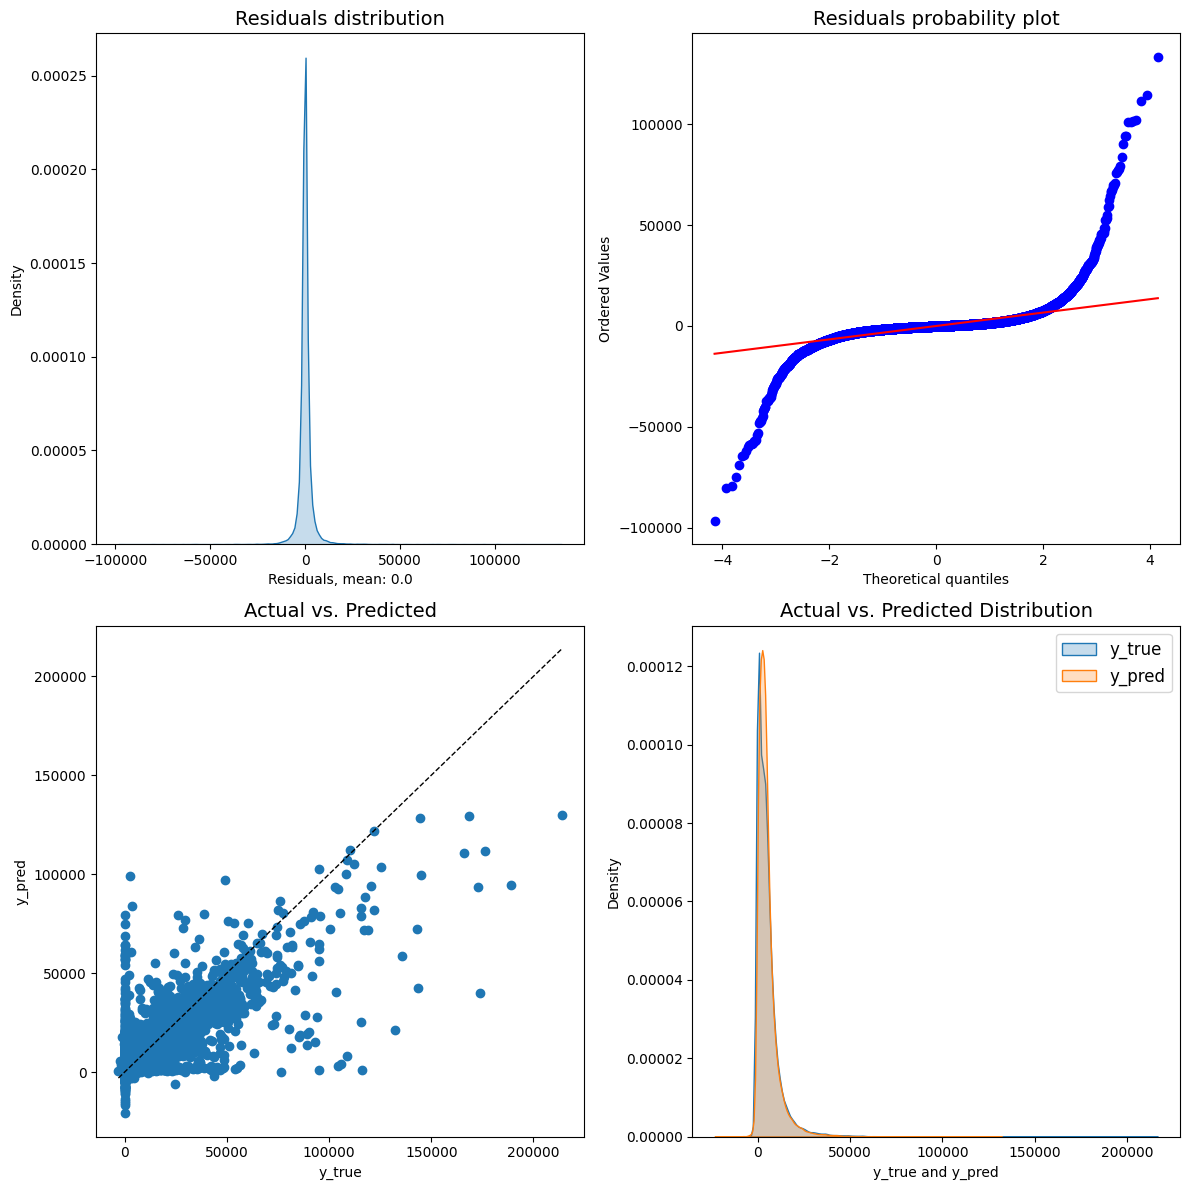

In [216]:
y_pred = linear_model.predict(X_train_numeric)
diagnostics(y_train, y_pred)

In [217]:
model_result

,Name,MAE
0,LinearRegression(),1.995673e+03
1,"RandomizedSearchCV(cv=10, estimator=SGDRegress...",8.666638e+22


In [218]:
from catboost import CatBoostRegressor

# Создаем модель
catboost_model = CatBoostRegressor(verbose=True)

# Определяем сетку параметров
grid = {
    'learning_rate': [ 0.1],
    'depth': [4],
    'l2_leaf_reg': [1],
    'iterations': [500],
    'border_count': [ 128],
    'boosting_type': ['Ordered', 'Plain']
}

# Выполняем случайный поиск
randomized_search_result = catboost_model.randomized_search(grid,
                                                            X=X_train,
                                                            y=y_train,
                                                            plot=True)

# Выводим лучшие параметры
print("Лучшие параметры:", randomized_search_result['params'])




MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 9073.3148415	test: 8738.3455750	best: 8738.3455750 (0)	total: 81.8ms	remaining: 40.8s
1:	learn: 8455.4238634	test: 8145.1989709	best: 8145.1989709 (1)	total: 125ms	remaining: 31.2s
2:	learn: 7885.7628447	test: 7632.7746835	best: 7632.7746835 (2)	total: 169ms	remaining: 28s
3:	learn: 7381.4222224	test: 7168.0290352	best: 7168.0290352 (3)	total: 203ms	remaining: 25.2s
4:	learn: 6926.7138539	test: 6770.9751843	best: 6770.9751843 (4)	total: 240ms	remaining: 23.8s
5:	learn: 6529.8405625	test: 6439.1356599	best: 6439.1356599 (5)	total: 269ms	remaining: 22.1s
6:	learn: 6169.4804006	test: 6130.4605730	best: 6130.4605730 (6)	total: 294ms	remaining: 20.7s
7:	learn: 5853.8936342	test: 5864.1955402	best: 5864.1955402 (7)	total: 318ms	remaining: 19.6s
8:	learn: 5586.1923942	test: 5629.0341418	best: 5629.0341418 (8)	total: 341ms	remaining: 18.6s
9:	learn: 5330.7647328	test: 5415.0704706	best: 5415.0704706 (9)	total: 360ms	remaining: 17.7s
10:	learn: 5125.0378614	test: 5237.5439413	best: 52

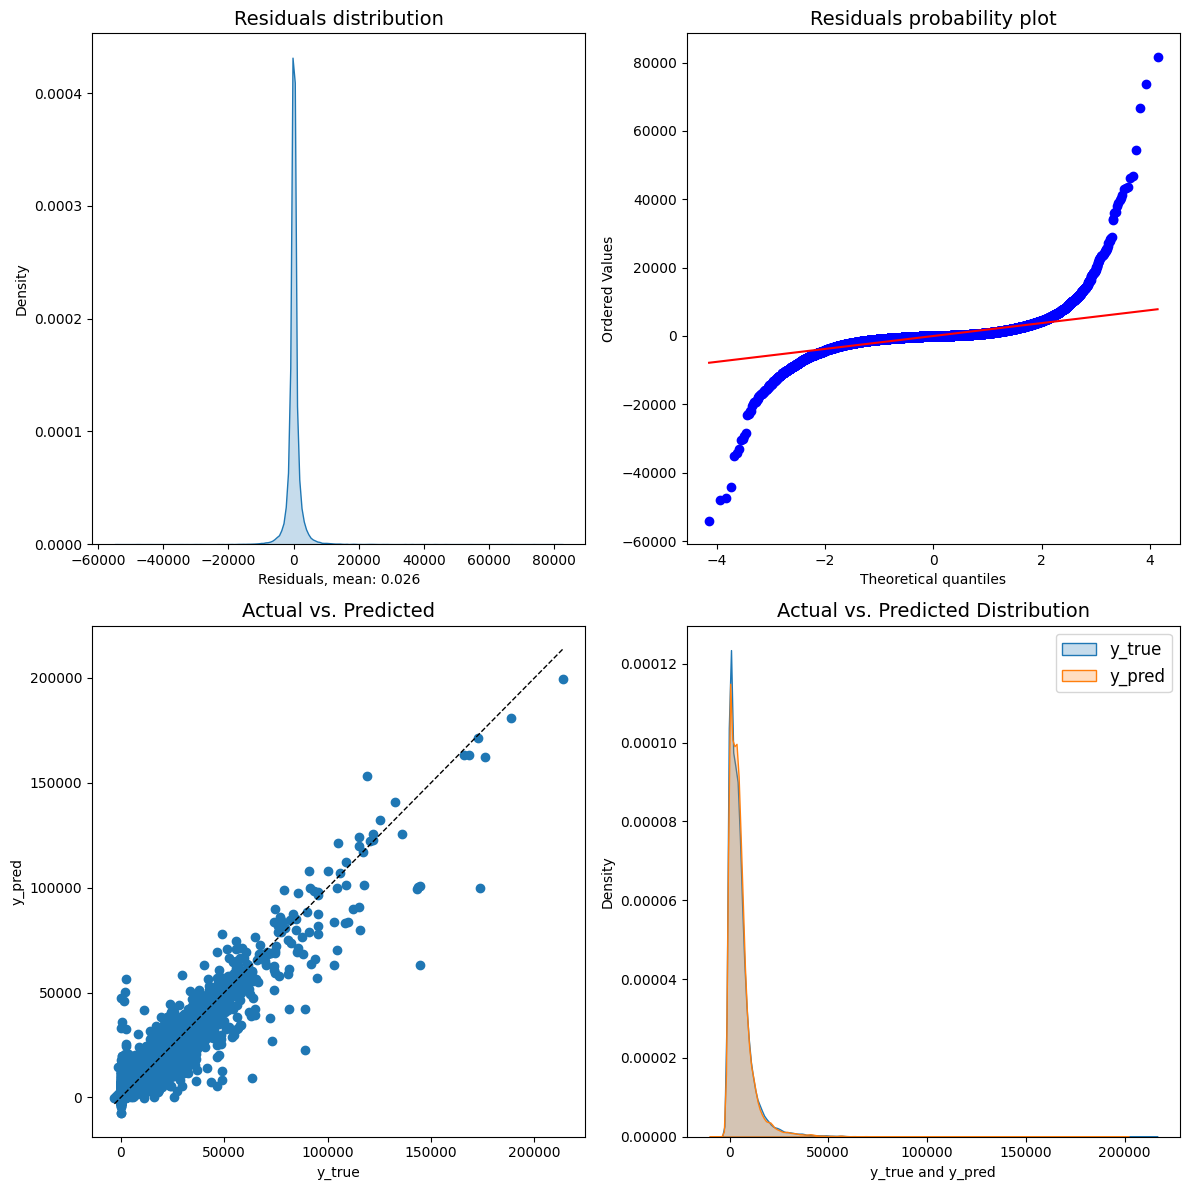

In [219]:
y_pred = catboost_model.predict(X_train)
diagnostics(y_train, y_pred)

In [220]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(catboost_model)
# Calculate Shap values
shap_values = explainer.shap_values(X_train)

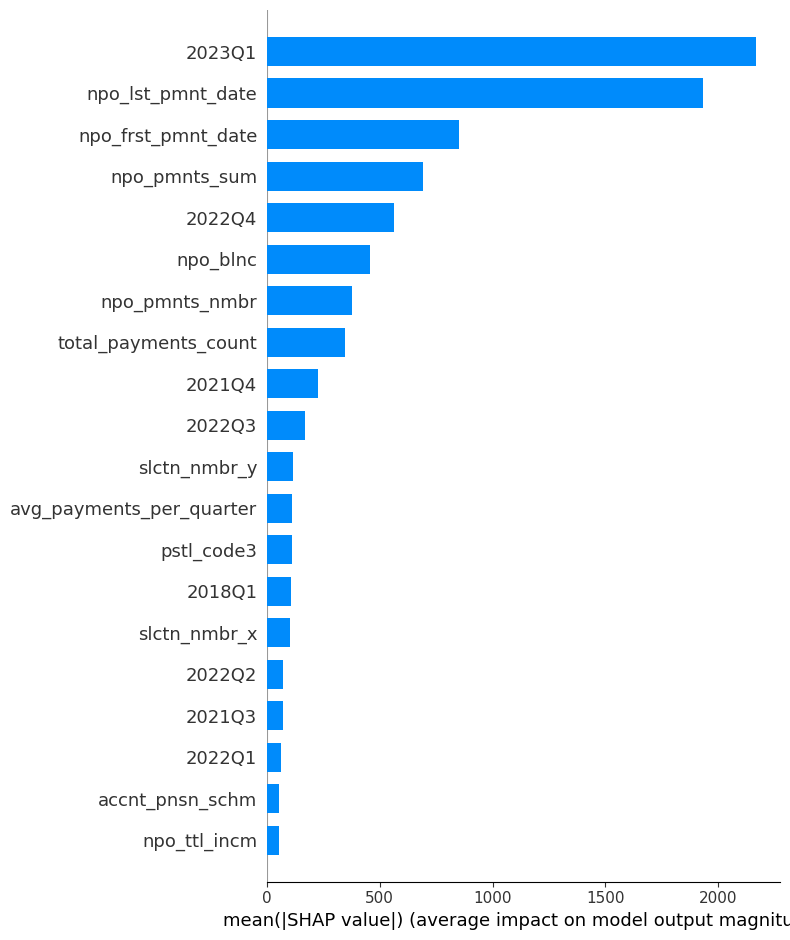

In [221]:
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, plot_type="bar")

c:\Users\Денис\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\plots\_beeswarm.py:699: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



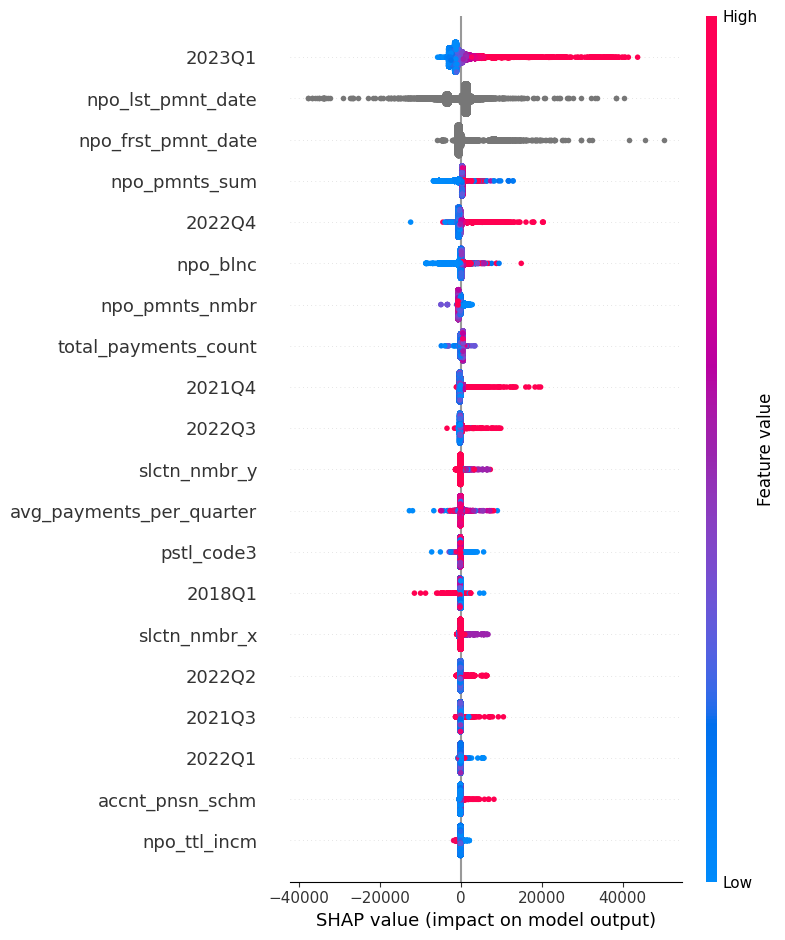

In [222]:
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

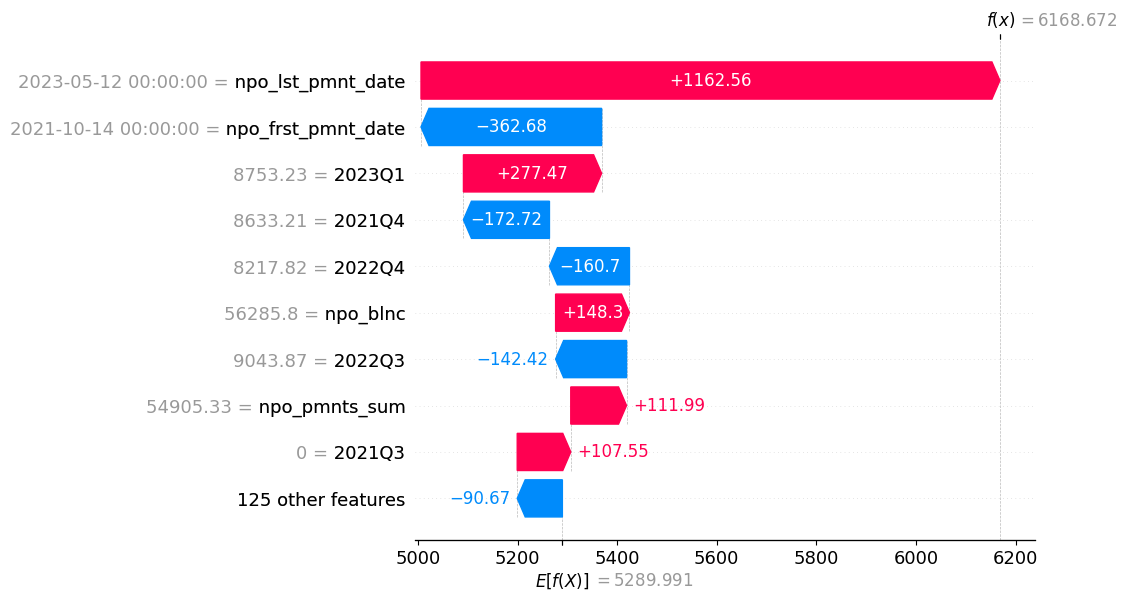

In [223]:
explainer = shap.Explainer(catboost_model)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

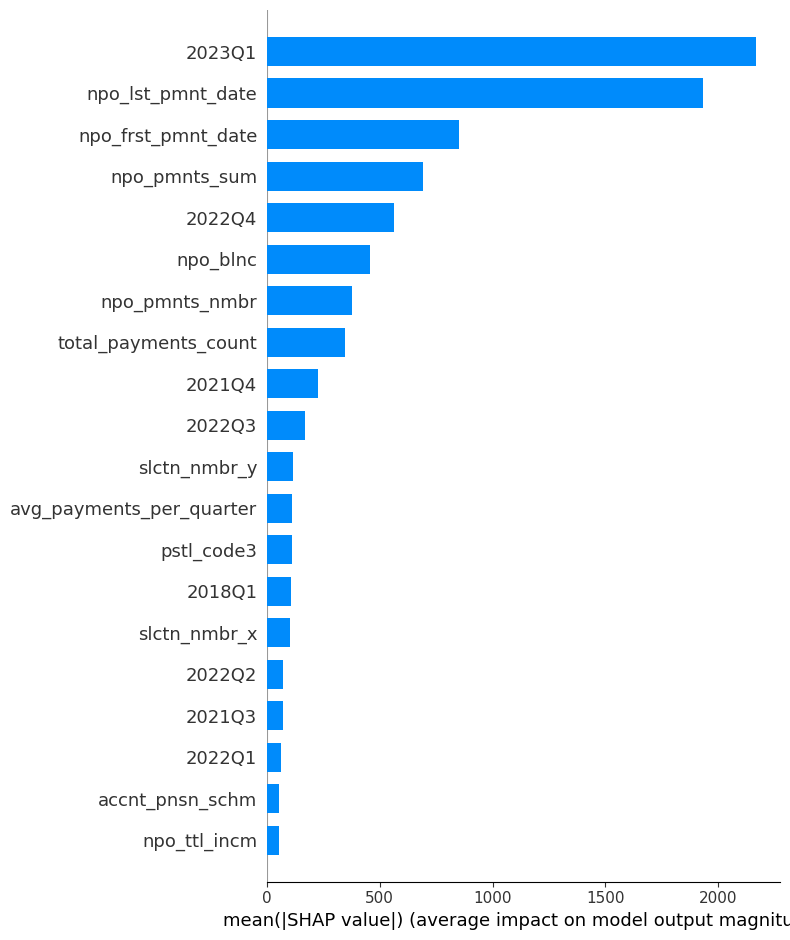

KeyboardInterrupt: 

In [224]:
# Визуализация важности признаков
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Получение индексов признаков, отсортированных по их среднему абсолютному SHAP значению
sorted_feature_indices = np.argsort(-np.abs(shap_values).mean(0))

# Отбор 15 наиболее важных признаков
top_15_features = X_train.columns[sorted_feature_indices[:15]]

# Создание нового датафрейма X_train_new
X_train_new = X_train[top_15_features]


In [226]:
top_15_features

Index(['2023Q1', 'npo_lst_pmnt_date', 'npo_frst_pmnt_date', 'npo_pmnts_sum',
       '2022Q4', 'npo_blnc', '2022Q3', 'npo_pmnts_nmbr', '2022Q2',
       'avg_payments_per_quarter', 'slctn_nmbr_y', '2020Q3', 'slctn_nmbr_x',
       'npo_ttl_incm', '2022Q1'],
      dtype='object')

In [225]:
sorted_feature_indices

array([133,   8,   7,  10, 132,   9, 131,  11, 130,  16,  15, 123,   1,
        12, 129,   5,  17, 119, 127, 126, 128,  14, 125, 115, 122, 120,
         0,   4, 124, 111, 113, 102,  91,   6, 117, 116,   2,  94,  99,
       118,  73, 103,  85, 121,  93,   3, 107, 110, 101,  81, 109, 112,
        89, 114,  96,  92, 105, 108,  87,  95,  84, 100,  79,  77,  82,
        90,  88,  98,  97, 104,  67,  60,  20,  63,  21, 106,  24,  23,
        22,  86,  19,  18,  13,  27,  80,  26,  48,  47,  46,  45,  44,
        43,  42,  41,  40,  39,  38,  37,  36,  35,  34,  33,  32,  31,
        30,  29,  28,  49,  83,  50,  52,  78,  76,  75,  74,  72,  71,
        70,  69,  68,  25,  65,  64,  62,  61,  59,  58,  57,  56,  55,
        54,  53,  51,  66], dtype=int64)

In [ ]:
from catboost import CatBoostRegressor

# Создаем модель
catboost_model = CatBoostRegressor(verbose=True)

# Определяем сетку параметров
grid = {
    'learning_rate': [ 0.1],
    'depth': [4],
    'l2_leaf_reg': [1],
    'iterations': [500],
    'border_count': [ 128],
    'boosting_type': ['Ordered', 'Plain']
}

# Выполняем случайный поиск
randomized_search_result = catboost_model.randomized_search(grid,
                                                            X=X_train_new,
                                                            y=y_train,
                                                            plot=True)

# Выводим лучшие параметры
print("Лучшие параметры:", randomized_search_result['params'])


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 8825.1549288	test: 8726.5777502	best: 8726.5777502 (0)	total: 16.2ms	remaining: 8.09s
1:	learn: 8197.1746601	test: 8111.8639812	best: 8111.8639812 (1)	total: 29.1ms	remaining: 7.24s
2:	learn: 7623.3257415	test: 7552.4675098	best: 7552.4675098 (2)	total: 36.6ms	remaining: 6.06s
3:	learn: 7132.6221981	test: 7070.1192765	best: 7070.1192765 (3)	total: 45.6ms	remaining: 5.66s
4:	learn: 6687.4133494	test: 6662.0549020	best: 6662.0549020 (4)	total: 56ms	remaining: 5.54s
5:	learn: 6292.8897539	test: 6285.5679461	best: 6285.5679461 (5)	total: 67ms	remaining: 5.51s
6:	learn: 5972.9348713	test: 5986.0476997	best: 5986.0476997 (6)	total: 75.7ms	remaining: 5.33s
7:	learn: 5664.7672241	test: 5694.1082056	best: 5694.1082056 (7)	total: 83.5ms	remaining: 5.13s
8:	learn: 5385.0246232	test: 5437.1410220	best: 5437.1410220 (8)	total: 90.9ms	remaining: 4.96s
9:	learn: 5141.6692027	test: 5212.2733372	best: 5212.2733372 (9)	total: 100ms	remaining: 4.9s
10:	learn: 4927.0293883	test: 5010.5134641	bes

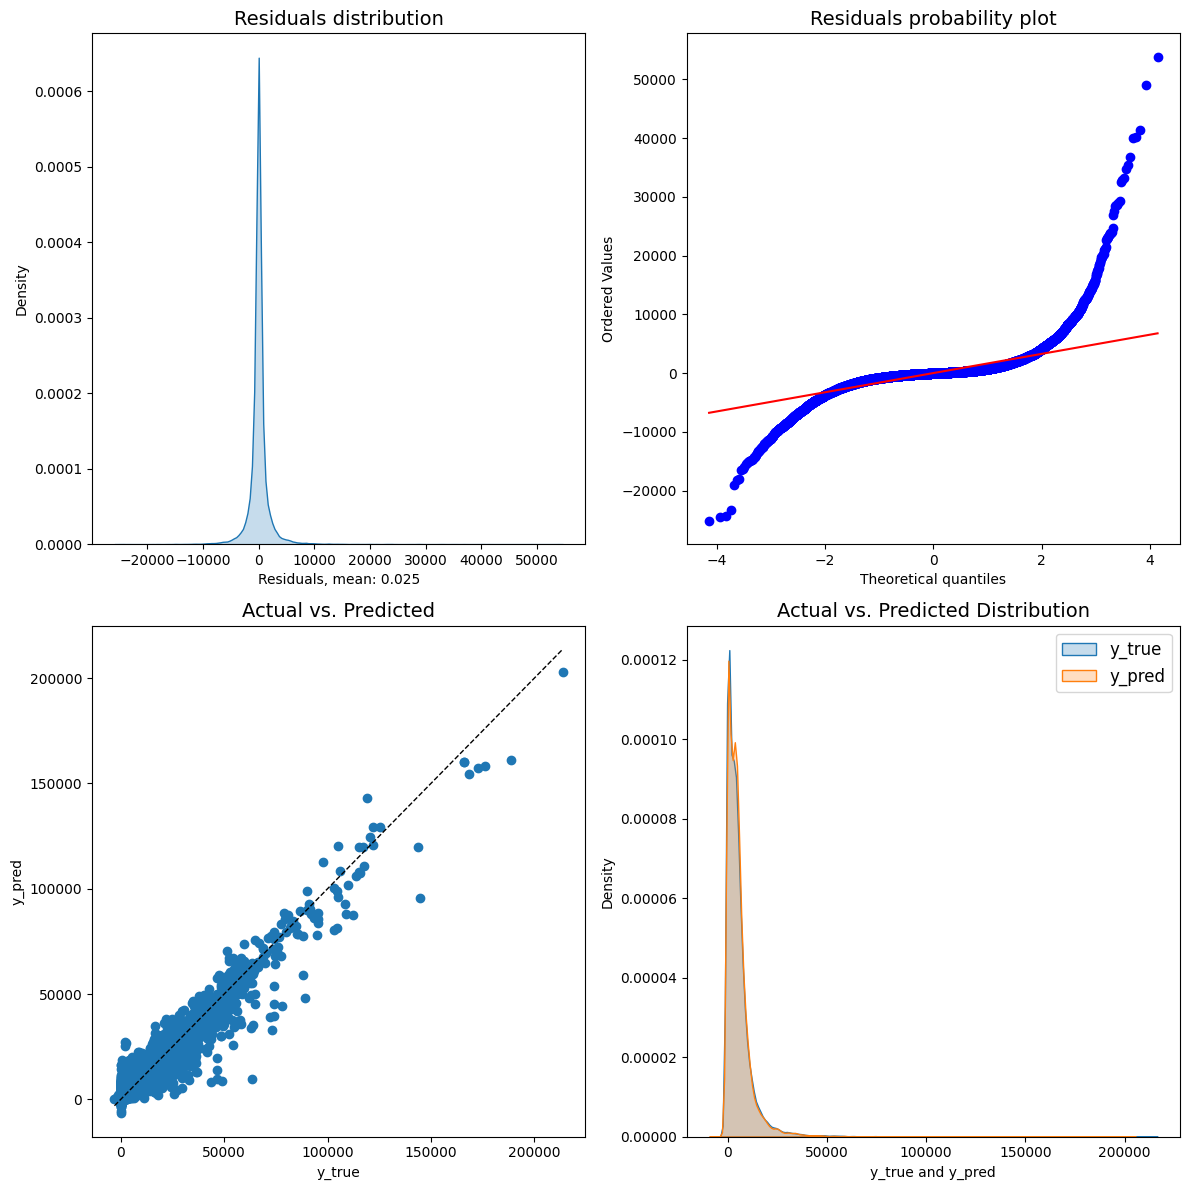

In [ ]:
y_pred = catboost_model.predict(X_train_new)
diagnostics(y_train, y_pred)

In [ ]:
catboost_model.save_model("catboost_model.cbm")

In [ ]:
column_mapping = {
    'I квартал 2013': 'Q1_2013',
    'II квартал 2013': 'Q2_2013',
    'III квартал 2013': 'Q3_2013',
    'IV квартал 2013': 'Q4_2013',
    '2013 год': 'Year_2013',
    'I квартал 2014': 'Q1_2014',
    'II квартал 2014': 'Q2_2014',
    'III квартал 2014': 'Q3_2014',
    'IV квартал 2014': 'Q4_2014',
    '2014 год': 'Year_2014',
    'I квартал 2015': 'Q1_2015',
    'II квартал 2015': 'Q2_2015',
    'III квартал 2015': 'Q3_2015',
    'IV квартал 2015': 'Q4_2015',
    '2015 год': 'Year_2015',
    'I квартал 2016': 'Q1_2016',
    'II квартал 2016': 'Q2_2016',
    'III квартал 2016': 'Q3_2016',
    'IV квартал 2016': 'Q4_2016',
    '2016 год': 'Year_2016',
    'I квартал 2017': 'Q1_2017',
    'II квартал 2017': 'Q2_2017',
    'III квартал 2017': 'Q3_2017',
    'IV квартал 2017': 'Q4_2017',
    '2017 год': 'Year_2017',
    'I квартал 2018': 'Q1_2018',
    'II квартал 2018': 'Q2_2018',
    'III квартал 2018': 'Q3_2018',
    'IV квартал 2018': 'Q4_2018', 
    '2018 год': 'Year_2018',
    'I квартал 2019': 'Q1_2019',
    'II квартал 2019': 'Q2_2019',
    'III квартал 2019': 'Q3_2019',
    'IV квартал 2019': 'Q4_2019',
    '2019 год': 'Year_2019',
    'I квартал 2020': 'Q1_2020',
    'II квартал 2020': 'Q2_2020',
    'III квартал 2020': 'Q3_2020',
    'IV квартал 2020': 'Q4_2020',
    '2020 год': 'Year_2020',
    'I квартал 2021': 'Q1_2021',
    'II квартал 2021': 'Q2_2021',
    'III квартал 2021': 'Q3_2021',
    'IV квартал 2021': 'Q4_2021',
    '2021 год': 'Year_2021',
    'I квартал 2022': 'Q1_2022',
    'II квартал 2022': 'Q2_2022',
    'III квартал 2022': 'Q3_2022',
    'IV квартал 2022': 'Q4_2022',
    '2022 год': 'Year_2022',
    'I квартал 2023': 'Q1_2023',
    'II квартал 2023': 'Q2_2023',
    'III квартал': 'Q3_2023',
    'IV квартал': 'Q4_2023',
    '2023 год': 'Year_2023'
}

dohod = dohod.rename(columns=column_mapping)


In [ ]:
# Добавляем префикс 'dohod_' к каждому значению в словаре column_mapping
column_mapping_with_prefix = {key: 'dohod_' + value for key, value in column_mapping.items()}

# Применяем переименование
dohod = dohod.rename(columns=column_mapping_with_prefix)
